<a href="https://colab.research.google.com/github/alanwuha/ce7455-nlp/blob/master/assignment-3/nlp-from-scratch-translation-with-a-sequence-to-sequence-network-and-attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP FROM SCRATCH: TRANSLATION WITH A SEQUENCE TO SEQUENCE NETWORK AND ATTENTION

### Import Modules

In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load and Prepare Data

The data for this project is a set of many thousands of English to French translation pairs.

In [48]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2020-04-01 05:54:52--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.192.151.21, 54.192.151.109, 54.192.151.68, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.192.151.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]   2.75M  --.-KB/s    in 0.03s   

2020-04-01 05:54:53 (90.4 MB/s) - ‘data.zip.1’ saved [2882130/2882130]

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Similar to the character encoding used in the character-level RNN tutorials, we will be representing each word in a language as a one-hot vector, or giant vector of zeros except for a single one (at the index of the word). Compared to the dozens of characters that might exist in a language, there are many many more words, so the encoding vector is much larger. We will however cheat a bit and trim the data to only use a few thousand words per language.

![diagram](https://pytorch.org/tutorials/_images/word-encoding.png)

We'll need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called `Lang` which has word -> index (`word2index`) and index -> word (`index2word`) dictionaries, as well as a count of each word `word2count` to use to later replace rare words.

In [0]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = { 0: 'SOS', 1: 'EOS' }
        self.n_words = 2 # Count SOS and EOS
        
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
            
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

In [0]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [0]:
print(unicodeToAscii("À l'aide !"))
print(normalizeString("À l'aide !"))

print(normalizeString("Go."))
print(normalizeString("Va !"))

A l'aide !
a l aide !
go .
va !


To read the data file we will split the file into lines, and then split lines into pairs. The files are all English -> Other Language, so if we want to translate from Other Language -> English I added the `reverse` flag to reverse the pairs.

In [0]:
def readLangs(lang1, lang2, reverse=False): # e.g. lang1 = eng, lang2 = fra
    print("Reading lines...")
    
    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')
    
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
        input_char = Char(lang2)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        input_char = Char(lang1)
        
    return input_lang, output_lang, input_char, pairs

Since there are a _lot_ of example sentences and we want to train something quickly, we'll trim the data set to only relatively short and simple sentence. Here the maximum length is 10 words (that includes ending punctuation) and we're filtering to sentences that translate to the form "I am" or "He is" etc. (accounting for apostrophes replaced earlier).

In [0]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p): # e.g. p = ['go.', 'va !']
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing that data is:
- Read text file and split into lines, split lines into pairs
- Normalize text filter by length and content
- Make word lists from sentences in pairs

In [64]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, input_char, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words and chars...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
        input_char.addSentence(pair[0])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    print("Counted chars:")
    print(input_char.name, input_char.n_chars)
    
    return input_lang, output_lang, input_char, pairs

input_lang, output_lang, input_char, pairs = prepareData('eng', 'fra', True)

print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words and chars...
Counted words:
fra 4345
eng 2803
Counted chars:
fra 29
['vous etes tres marrant .', 'you re very funny .']


In [65]:
print(input_char.char2index)
print(input_char.char2count)
print(input_char.index2char)
print(input_char.n_chars)

{'j': 0, 'a': 1, 'i': 2, 'n': 3, 's': 4, '.': 5, 'e': 6, 'v': 7, 'b': 8, 'c': 9, 'u': 10, 'g': 11, 'r': 12, 'o': 13, 'f': 14, 'm': 15, 't': 16, 'h': 17, '!': 18, 'l': 19, 'd': 20, 'p': 21, 'z': 22, 'x': 23, 'y': 24, 'q': 25, 'k': 26, '?': 27, 'w': 28}
{'j': 4774, 'a': 13819, 'i': 15983, 'n': 15628, 's': 27771, '.': 10262, 'e': 40222, 'v': 4630, 'b': 1642, 'c': 5537, 'u': 16566, 'g': 1742, 'r': 12076, 'o': 13499, 'f': 2316, 'm': 6719, 't': 15608, 'h': 1468, '!': 197, 'l': 9856, 'd': 5313, 'p': 6098, 'z': 407, 'x': 747, 'y': 415, 'q': 1192, 'k': 37, '?': 145, 'w': 13}
{0: 'j', 1: 'a', 2: 'i', 3: 'n', 4: 's', 5: '.', 6: 'e', 7: 'v', 8: 'b', 9: 'c', 10: 'u', 11: 'g', 12: 'r', 13: 'o', 14: 'f', 15: 'm', 16: 't', 17: 'h', 18: '!', 19: 'l', 20: 'd', 21: 'p', 22: 'z', 23: 'x', 24: 'y', 25: 'q', 26: 'k', 27: '?', 28: 'w'}
29


In [0]:
def wordIndexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = wordIndexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### The Decoder

In [0]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

### Attention Decoder

In [0]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        
        return output, hidden, attn_weights
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Plotting results

Plotting is done with matplotlib, using the array of loss values `plot_losses` saved while training.

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points):
    print('showPlot')
    plt.figure()
    fig, ax = plt.subplots()
    # this locater puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.

In [0]:
import time

def asMinutes(s):
    m = s // 60
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

## Here's What's Changed

### The CNN Model for Generating Character Embeddings

Consider the word 'cat', we pad it on both ends to get our maximum word length (this is mainly an implementation quirk since we can't have variable length layers at run time, our algorithm will ignore the pads).

We then apply a convolution layer on top that generates spatial coherence across characters, we use a maxpool to extract meaningful features out of our convolution layer. This now gives us a dense vector representation of each word.

__This representation will then be concatenated with the word embedding to become the input of the GRU layer in EncoderRNN__.

![cnn_model](https://raw.githubusercontent.com/TheAnig/NER-LSTM-CNN-Pytorch/master/images/cnn_model.png)

This snippet shows us how the CNN is implemented in PyTorch.

```
self.char_cnn3 = nn.Conv2d(in_channels=1, out_channels=char_representation_dim, kernel_size=(3, char_embedding_dim), padding=(2, 0))
```

We define a new `Char` class that stores the char2index, char2count, and index2char dictionaries for a given language to be used for character-level encoding.

In [0]:
class Char:
    def __init__(self, name):
        self.name = name
        self.char2index = {}
        self.char2count = {}
        self.index2char = {}
        self.n_chars = 0
        
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
            
    def addWord(self, word):
        for char in word:
            self.addChar(char)
            
    def addChar(self, char):
        if char not in self.char2index:
            self.char2index[char] = self.n_chars
            self.char2count[char] = 1
            self.index2char[self.n_chars] = char
            self.n_chars += 1
        else:
            self.char2count[char] += 1

We add two new methods `charIndexesFromSentence` and `charIndexesFromWord` to retrieve character indexes for a given input sentence for be used for our character-level encoding.

In [0]:
def charIndexesFromSentence(char, sentence):
    return [charIndexesFromWord(char, word) for word in sentence.split(' ')]

def charIndexesFromWord(char, word):
    return [char.char2index[character] for character in word]

In [0]:
sentence = 'je t aime'
print(sentence)
print(charIndexesFromSentence(input_char, sentence))

je t aime
[[0, 6], [16], [1, 2, 15, 6]]


### The Encoder

We modify the original EncoderRNN to include a character-level encoder to generate a character representation given an input word. This character representation will then be concatenated with the word embedding and passed as input into the GRU layer to generate the output and hidden vectors for each word in a sequence.

In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, n_chars, n_words, hidden_size, char_embedding_dim=25, char_representation_dim=25):
        """
        Input parameters:
            n_chars = Number of unique characters in input language
            n_words = Number of unique words in input language
            hidden_size = Dimension of GRU input and output.
            char_embedding_dim = Dimension of the character embeddings
            char_representation_dim = Output dimension from the CNN encoder for character
        """
        super(EncoderRNN, self).__init__()

        # Parameters
        self.n_chars = n_chars
        self.char_embedding_dim = char_embedding_dim
        self.char_representation_dim = char_representation_dim
        self.n_words = n_words
        self.hidden_size = hidden_size

        # Character-level encoder
        self.char_embedding_layer = nn.Embedding(n_chars, char_embedding_dim)
        self.char_cnn3_layer = nn.Conv2d(in_channels=1, out_channels=char_representation_dim, kernel_size=(3, char_embedding_dim), padding=(2, 0))
        
        # Word embedding layer
        self.word_embedding_layer = nn.Embedding(n_words, hidden_size - char_representation_dim) # Dimension of the word embeddings is automatically derived as hidden_size - char_representation_dim
        
        # GRU layer
        self.gru = nn.GRU(hidden_size, hidden_size)

        # Weights
        self.initEmbedding(self.char_embedding_layer.weight)
        
    def forward(self, char_indexes, word_index, hidden):
        # Get char representation
        char_embedding = self.char_embedding_layer(char_indexes).unsqueeze(1)
        char_cnn3 = self.char_cnn3_layer(char_embedding).squeeze(-1).unsqueeze(1)
        char_representation = F.max_pool2d(char_cnn3, kernel_size=(1, char_cnn3.size(-1))).squeeze(-1)

        # Get word embedding
        word_embedding = self.word_embedding_layer(word_index).view(1, 1, -1)

        # Concatenate char representation with word embedding
        combined = torch.cat((char_representation, word_embedding), dim=2)

        # Feed combined and hidden to GRU
        output, hidden = self.gru(combined, hidden)

        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

    def initEmbedding(self, input_embedding):
      """
      Initialize embedding
      """
      bias = np.sqrt(3.0 / input_embedding.size(1))
      nn.init.uniform_(input_embedding, -bias, bias)

### Training the Model

We modify `TrainIter` to train on 80% of the training data for a given number of epochs.

In [0]:
def trainIters(encoder, char_cnn3, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    char_cnn3_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    training_pairs = []
    training_char_indexes = []
    for i in range(n_iters):
        pair = random.choice(pairs)
        training_pairs.append(tensorsFromPair(pair))
        training_char_indexes.append(charIndexesFromSentence(input_char, pair[0]))

    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        input_char_indexes = training_char_indexes[iter - 1]

        loss = train(input_tensor, target_tensor, input_char_indexes, encoder, char_cnn3,
                     decoder, encoder_optimizer, char_cnn3_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

We modify the encoder's forward pass method (line 24) to take in character indexes for each input word.

In [0]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, input_char_indexes, encoder, char_cnn3, decoder, encoder_optimizer, char_cnn3_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    char_cnn3_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    # Pad input_char_indexes with zero indexes if sequence has fewer than max_length words
    if len(input_char_indexes) < max_length:
      input_char_indexes += [[0]] * (max_length - len(input_char_indexes))

    loss = 0

    for ei in range(input_length):
        # Modify encoder forward pass method to take in character indexes of the input word
        encoder_output, encoder_hidden = encoder(torch.LongTensor([input_char_indexes[ei]]).to(device), input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
        
    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):

            # Train using DecoderRNN
            # decoder_output, decoder_hidden = decoder(
            #     decoder_input, decoder_hidden)

            # Train using AttnDecoderRNN
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):

            # Train using DecoderRNN
            # decoder_output, decoder_hidden = decoder(
            #     decoder_input, decoder_hidden)

            # Train using AttnDecoderRNN
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    char_cnn3_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

### Training and Evaluating

2m 12s (- 30m 50s) (5000 6%) 2.8141
4m 18s (- 27m 57s) (10000 13%) 2.2201
6m 25s (- 25m 40s) (15000 20%) 1.8858
8m 31s (- 23m 25s) (20000 26%) 1.6058
10m 36s (- 21m 13s) (25000 33%) 1.4286
12m 41s (- 19m 2s) (30000 40%) 1.2735
14m 47s (- 16m 53s) (35000 46%) 1.1322
16m 52s (- 14m 45s) (40000 53%) 1.0206
18m 55s (- 12m 37s) (45000 60%) 0.8901
20m 59s (- 10m 29s) (50000 66%) 0.8215
23m 2s (- 8m 22s) (55000 73%) 0.7567
25m 6s (- 6m 16s) (60000 80%) 0.6757
27m 12s (- 4m 11s) (65000 86%) 0.6197
29m 18s (- 2m 5s) (70000 93%) 0.5856
31m 23s (- 0m 0s) (75000 100%) 0.5425
showPlot


<Figure size 432x288 with 0 Axes>

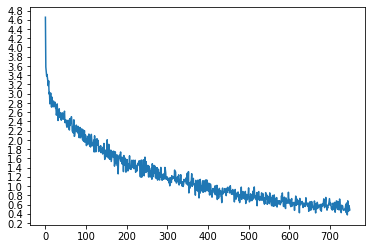

In [130]:
hidden_size = 256
char_embedding_dim = 25
char_representation_dim = 25

encoder1 = EncoderRNN(input_char.n_chars, input_lang.n_words, hidden_size, char_embedding_dim, char_representation_dim).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, char_cnn3, attn_decoder1, 75000, print_every=5000)